In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from numpy.linalg import multi_dot
import matplotlib.pyplot as plt

# Load stock price data and ESG scores, setting 'Dates' as the index
Stocks_Data = pd.read_excel('Greenwashing Stock Prices.xlsx').set_index('Dates')
ESG_Data = pd.read_excel('Greenwashing ESG Scores.xlsx').set_index('Dates')

# Compute ESG deficiency scores (difference from the ideal score of 100)
ESG_Deficiency_Scores = 101 - ESG_Data

In [2]:
# Will end up obtaining r_0
# Initialize return storage and investment parameters
Returns = []  # Stores portfolio returns (k×1 vector)
Dates = []  # Stores dates of testing periods
DatesTraded = []  # Stores dates when trades occur
Capital = 1e9  # Initial investment capital ($1 billion)
Delta = 1  # Portfolio rebalancing 
t_1 = round(len(Stocks_Data)* 0.75)
 
for i in range(t_1, len(Stocks_Data), Delta):
    # Training data: first 75% of stock price data
    Stocks_Training = Stocks_Data.iloc[0:i]  # (i × n) matrix where n is the number of assets
    Stocks_Testing = Stocks_Data.iloc[i:i+1]  # (1 × n) matrix for next period returns
    ESG = ESG_Deficiency_Scores.iloc[0:i]  # (i × n) matrix of ESG scores
    
    N = len(Stocks_Training.columns)  # Number of assets 
    
    # Compute daily returns: (S_{t+1} - S_t) / S_t
    rts = (Stocks_Training.iloc[1:, :].values - Stocks_Training.iloc[:-1, :].values) / Stocks_Training.iloc[:-1, :].values  # ((i-1) × n)
    hist_avg = np.mean(rts, axis=0)  # (n × 1) vector of historical mean returns

    # Quadratic programming parameters
    Q = np.cov(np.transpose(rts))  # (n × n) covariance matrix
    A = np.ones((1, N))  # (1 × n) row vector enforcing sum of weights = 1
    c = hist_avg.reshape([N, 1])  # (n × 1) column vector of expected returns
    b = np.array([1])  # Scalar constraint for total investment
    G = ESG.iloc[-1].to_numpy().reshape(1, N)  # (1 × n) row vector of ESG scores
    h = np.asarray([25], dtype=float)  # ESG constraint scalar

    # Compute intermediate terms for Lagrange multipliers
    a1 = A @ np.linalg.inv(Q) @ A.T  # (1 × 1) scalar
    a2 = A @ np.linalg.inv(Q) @ G.T  # (1 × 1) scalar
    a3 = G @ np.linalg.inv(Q) @ G.T  # (1 × 1) scalar

    # Solve for Lagrange multipliers λ_1 and λ_2
    lambda1 = (-a3 * (1 - A @ np.linalg.inv(Q) @ c) + a2 * (h - G @ np.linalg.inv(Q) @ c)) / (a1 * a3 - a2 * a2)
    lambda2 = (a2.T * (1 - A @ np.linalg.inv(Q) @ c) - a1 * (h - G @ np.linalg.inv(Q) @ c)) / (a1 * a3 - a2 * a2)

    # Compute optimal weights x (n × 1)
    x = np.linalg.inv(Q) @ c - lambda1.item() * np.linalg.inv(Q) @ A.T - lambda2.item() * np.linalg.inv(Q) @ G.T
    x = np.reshape(x, (N,))  # Reshape x for matrix operations

    # Calculate returns using testing data
    LastClosingPrice = Stocks_Training.iloc[-1]  # (n × 1) vector of last training prices
    AmtofShares = np.floor((x * Capital) / LastClosingPrice)  # (n × 1) vector of shares purchased
    Abs_Returns = (AmtofShares * Stocks_Testing.to_numpy().flatten() - AmtofShares * LastClosingPrice.values)  # (n × 1) vector of profit/loss
    Percent_Returns = np.sum(Abs_Returns) / Capital  # Scalar percentage return

    # Store results
    Returns.append(Percent_Returns)
    Dates.append(Stocks_Testing.index)
    DatesTraded.append(Stocks_Training.index[-1])

# Create a DataFrame for benchmark returns
# df1 stores r_0, the benchmark return vector across all testing periods.
df1 = pd.DataFrame({'Benchmark Returns': Returns}, index=np.array(Dates).reshape(-1))


In [3]:
# G_hat to obtain r_delta
Returns = []  # Stores r_delta, the portfolio returns under adjusted ESG deficiencies
Dates = []  # Stores testing period dates
DatesTraded = []  # Stores dates when trades occur
Capital = 1e9  # Initial investment capital ($1 billion)
thres = 1.20  # Lambda; ESG deficiency score increase factor (i.e., 20% more)

# Loop through the data
for i in range(round(len(Stocks_Data) * 0.75), len(Stocks_Data), Delta):
    # Training data: first 75% of stock price data
    Stocks_Training = Stocks_Data.iloc[0:i]  # (i × n) matrix where n is the number of assets
    Stocks_Testing = Stocks_Data.iloc[i:i + 1]  # (1 × n) matrix for next period returns
    ESG = ESG_Deficiency_Scores.iloc[0:i]  # (i × n) matrix of ESG deficiency scores
    N = len(Stocks_Training.columns)  # Number of assets (n)

    # Compute daily returns: (S_{t+1} - S_t) / S_t
    rts = (Stocks_Training.iloc[1:, :].values - Stocks_Training.iloc[:-1, :].values) / Stocks_Training.iloc[:-1, :].values  # ((i-1) × n)
    hist_avg = np.mean(rts, axis=0)  # (n × 1) vector of historical mean returns

    # Quadratic programming parameters
    Q = np.cov(np.transpose(rts))  # (n × n) covariance matrix
    A = np.ones((1, N))  # (1 × n) row vector enforcing sum of weights = 1
    c = hist_avg.reshape([N, 1])  # (n × 1) column vector of expected returns
    b = np.array([1])  # Scalar constraint for total investment
    G = ESG.iloc[-1].to_numpy().reshape(1, N)  # (1 × n) row vector of ESG deficiency scores
    
    # Construct G_hat by modifying ESG deficiencies
    D = np.ones((1, N))  # Row vector for storing modified ESG deficiencies
    G_hat = np.ones((N, N)) * G  # Matrix where each row represents one company's adjusted ESG deficiencies

    # Modify ESG deficiency scores by λ
    for j in range(len(G_hat)):
        D[0][j] = 101 if G_hat[0][j] > (101 / thres) else thres * G_hat[0][j]
    np.fill_diagonal(G_hat, D)  # Replace diagonal with adjusted ESG deficiencies

    # Solve the quadratic programming optimization for each modified G_delta
    for k in range(len(G_hat)):
        G = G_hat[k].reshape(1, N)  # Extract row corresponding to modified ESG deficiencies
        h = np.asarray([25], dtype=float)  # ESG constraint

        # Compute intermediate terms for Lagrange multipliers
        a1 = A @ np.linalg.inv(Q) @ A.T  # (1 × 1) scalar
        a2 = A @ np.linalg.inv(Q) @ G.T  # (1 × 1) scalar
        a3 = G @ np.linalg.inv(Q) @ G.T  # (1 × 1) scalar

        # Solve for Lagrange multipliers λ_1 and λ_2
        lambda1 = (-a3 * (1 - A @ np.linalg.inv(Q) @ c) + a2 * (h - G @ np.linalg.inv(Q) @ c)) / (a1 * a3 - a2 * a2)
        lambda2 = (a2.T * (1 - A @ np.linalg.inv(Q) @ c) - a1 * (h - G @ np.linalg.inv(Q) @ c)) / (a1 * a3 - a2 * a2)

        # Compute optimal weights 'x' (n × 1)
        x = np.linalg.inv(Q) @ c - lambda1.item() * np.linalg.inv(Q) @ A.T - lambda2.item() * np.linalg.inv(Q) @ G.T
        x = np.reshape(x, (N,))  # Reshape x for matrix operations

        # Calculate portfolio returns under modified ESG deficiency
        LastClosingPrice = Stocks_Training.iloc[-1]  # (n × 1) vector of last training prices
        AmtofShares = np.floor((x * Capital) / LastClosingPrice)  # (n × 1) vector of shares purchased
        Abs_Returns = (AmtofShares * Stocks_Testing.to_numpy().reshape(-1) - AmtofShares * LastClosingPrice)  # (n × 1) vector of profit/loss
        Percent_Returns = np.sum(Abs_Returns) / Capital  # Scalar percentage return

        # Store results
        Returns.append(Percent_Returns)
        Dates.append(Stocks_Testing.index)
        DatesTraded.append(Stocks_Training.index[-1])



In [4]:
# Compute the number of trades (num_trades) and the number of stocks (num_stocks)
num_trades = round((len(Stocks_Data) - round(len(Stocks_Data) * 0.75)) / Delta)  # Number of rebalancing periods
num_stocks = len(Stocks_Training.columns)  # Total number of assets (n) in the portfolio

# Initialize 'T' to store return vectors for each trade period (T1 to T_{num_trades})
T = []

# Partition 'Returns' into trade-specific return arrays (T1 to T_{num_trades})
for i in range(num_trades):
    start_idx = i * num_stocks  # Index where the trade period starts
    end_idx = (i + 1) * num_stocks  # Index where the trade period ends
    T.append(np.array(Returns[start_idx:end_idx]).reshape(1, -1))  # Store as (1 × n) row vector

# 'T' is a list where each element is a NumPy array of shape (1 × n), representing returns for a given trade period

In [5]:
# Initialize an empty list to store DataFrames for each trade period
D_list = []

# Iterate through each trade period to create DataFrames
for i in range(num_trades):
    # Calculate the starting and ending indices for this trade period
    start_idx = i * num_stocks
    end_idx = (i + 1) * num_stocks
    
    # Create a DataFrame 'D' with trade-specific returns, matching columns, and index
    D = pd.DataFrame(data=T[i], columns=Stocks_Training.columns, index=np.array(Dates[start_idx]))
    
    # Append the DataFrame 'D' to the list of DataFrames
    D_list.append(D)

# Concatenate all DataFrames in 'D_list' vertically to form a single DataFrame 'R'
R = pd.concat(D_list)
R

,GOOGL_PX_LAST,DIS_PX_LAST,TMUS_PX_LAST,CMCSA_PX_LAST,AMZN_PX_LAST,TSLA_PX_LAST,HD_PX_LAST,MCD_PX_LAST,NKE_PX_LAST,LOW_PX_LAST,...,EQIX_PX_LAST,CCI_PX_LAST,PSA_PX_LAST,O_PX_LAST,NEE_PX_LAST,DUK_PX_LAST,SO_PX_LAST,D_PX_LAST,SRE_PX_LAST,AEP_PX_LAST
2020-02-25,-0.048671,-0.047783,-0.048809,-0.049390,-0.050496,-0.050007,-0.053123,-0.049151,-0.048811,-0.048025,...,-0.049154,-0.045717,-0.045753,-0.046731,-0.063024,-0.045799,-0.043540,-0.042293,-0.048822,-0.051335
2020-02-26,0.015953,0.018726,0.016005,0.015994,0.015243,0.015657,0.014322,0.017076,0.015862,0.017183,...,0.015935,0.015216,0.012847,0.020568,0.009726,0.015375,0.020671,0.019388,0.016207,0.015728
2020-02-27,-0.001259,-0.001801,-0.001395,-0.000758,0.000093,0.001276,0.001759,-0.002130,-0.001282,-0.001137,...,-0.001146,0.002539,-0.002072,-0.001283,0.012109,-0.004587,-0.010115,-0.003770,-0.001572,0.004437
2020-02-28,0.004996,0.004490,0.005001,0.005269,0.005175,0.005250,0.006690,0.006835,0.004412,0.004699,...,0.005910,0.006365,0.003681,0.002867,-0.002510,0.005856,0.009004,0.009048,0.004483,0.005050
2020-03-02,0.395069,0.398219,0.395034,0.393461,0.393843,0.392142,0.390736,0.397337,0.395037,0.395461,...,0.394092,0.393628,0.398326,0.403523,0.375249,0.396943,0.405586,0.397213,0.396136,0.389425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-04,0.106927,0.107062,0.106796,0.106916,0.106807,0.106873,0.107226,0.106925,0.107124,0.106834,...,0.106720,0.107655,0.106568,0.106823,0.107614,0.107021,0.106170,0.106635,0.106926,0.106924
2023-05-05,0.119421,0.119174,0.119520,0.119661,0.119555,0.119641,0.119586,0.119601,0.119304,0.119432,...,0.119434,0.118847,0.119298,0.119103,0.121039,0.119047,0.118736,0.118574,0.119567,0.119827
2023-05-08,0.039344,0.039266,0.039365,0.039412,0.039501,0.039317,0.039441,0.039353,0.039381,0.039415,...,0.039356,0.039833,0.039277,0.039513,0.038558,0.039528,0.040007,0.039419,0.039351,0.039155
2023-05-09,-0.084490,-0.084402,-0.084631,-0.084303,-0.084741,-0.084860,-0.084754,-0.084584,-0.084265,-0.084599,...,-0.084509,-0.083980,-0.084787,-0.083957,-0.085664,-0.084252,-0.085218,-0.083044,-0.084801,-0.084494


In [6]:
diff_vector = []  # Vector to store the differences (r_0 - r_delta) for each company
num_vector = []   # Number of times (r_0 - r_delta) is negative for each company

for col in R.columns:
    # Calculate the difference vector for a company
    diff_vector.append(df1['Benchmark Returns'] - R[col])
    
    # Count the number of times (r_0 - r_delta) is negative for the company
    num_negative = np.sum((df1['Benchmark Returns'] - R[col] < 0).values.ravel())
    num_vector.append(num_negative) 

num_vector  # List of counts for each company

# Create a list of stock tickers
stock_tickers = R.columns.tolist()

# Create a DataFrame with stock tickers and corresponding num_vector values
nums_df = pd.DataFrame({'Stock Ticker': stock_tickers, 'Num Negative Returns': num_vector})

# Display the resulting DataFrame
nums_df

,Stock Ticker,Num Negative Returns
0,GOOGL_PX_LAST,403
1,DIS_PX_LAST,428
2,TMUS_PX_LAST,422
3,CMCSA_PX_LAST,386
4,AMZN_PX_LAST,391
5,TSLA_PX_LAST,376
6,HD_PX_LAST,376
7,MCD_PX_LAST,401
8,NKE_PX_LAST,403
9,LOW_PX_LAST,392


In [7]:
num_loops = round((len(Stocks_Data)*.25)/Delta) #Number of times are checking r_0 -r_delta

GW_vec = np.ones((1,len(num_vector)))
for i in range(0,len(num_vector)):
    if num_vector[i] > .5*num_loops: #If more than 50% of the time there is negative returns, then we will consider that company greenwashing
        GW_vec[0][i] = 1
    else:
        GW_vec[0][i] = 0
GW_vec #1 means greenwashing. 0 means no greenwashing.

array([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
        1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0.]])

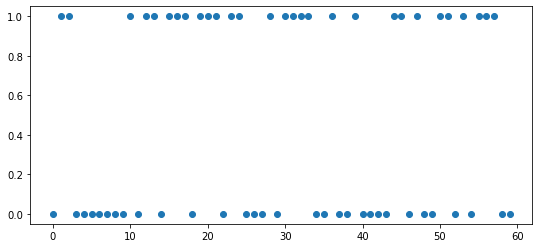

In [8]:
#visualizing amount of companies that are greenwashings vs not greenwashing
plt.figure(figsize=(9, 4))
plt.plot(GW_vec[0],'o')

In [9]:
#Number of companies Greenwashing
np.sum(GW_vec[0] == 1).ravel()

array([29])

In [10]:
#List of company stock tickers that are Greenwashing
R.iloc[:,np.where(GW_vec[0] == 1)[0]].columns

Index(['DIS_PX_LAST', 'TMUS_PX_LAST', 'WMT_PX_LAST', 'KO_PX_LAST',
       'PEP_PX_LAST', 'PM_PX_LAST', 'XOM_PX_LAST', 'CVX_PX_LAST',
       'SLB_PX_LAST', 'EOG_PX_LAST', 'BRK/B_PX_LAST', 'BAC_PX_LAST',
       'WFC_PX_LAST', 'JNJ_PX_LAST', 'MRK_PX_LAST', 'PFE_PX_LAST',
       'UPS_PX_LAST', 'RTX_PX_LAST', 'BA_PX_LAST', 'MSFT_PX_LAST',
       'APD_PX_LAST', 'FCX_PX_LAST', 'NEM_PX_LAST', 'EQIX_PX_LAST',
       'CCI_PX_LAST', 'O_PX_LAST', 'DUK_PX_LAST', 'SO_PX_LAST', 'D_PX_LAST'],
      dtype='object')

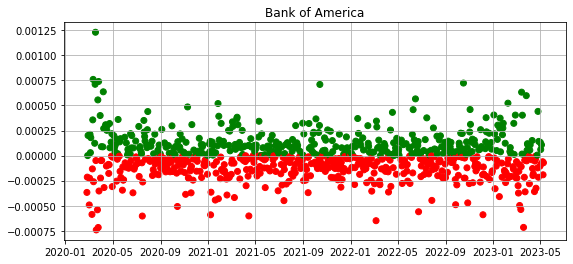

In [11]:
#visualizing the difference vector, d_1, as an example
plt.figure(figsize=(9, 4))
spread = df1['Benchmark Returns'] - R['BAC_PX_LAST']
col = np.where(spread > 0,'g','r')

plt.scatter(R.index,spread,c=col)
plt.grid()
plt.title("Bank of America")

# Save the figure automatically
plt.savefig("BAC_spread.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

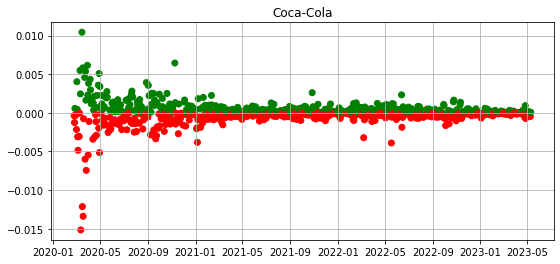

In [12]:
#visualizing the difference vector, d_1, as an example
plt.figure(figsize=(9, 4))
spread = df1['Benchmark Returns'] - R['KO_PX_LAST']
col = np.where(spread > 0,'g','r')

plt.scatter(R.index,spread,c=col)
plt.grid()
plt.title("Coca-Cola")

# Save the figure automatically
plt.savefig("coca_cola_spread.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

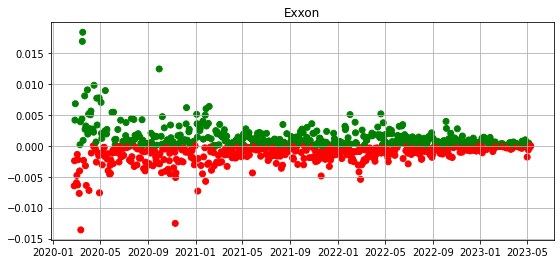

In [13]:
#visualizing the difference vector, d_1, as an example
plt.figure(figsize=(9, 4))
spread = df1['Benchmark Returns'] - R['XOM_PX_LAST']
col = np.where(spread > 0,'g','r')

plt.scatter(R.index,spread,c=col)
plt.grid()
plt.title("Exxon")

# Save the figure automatically
plt.savefig("exxon_spread.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()